In [1]:
# import packages
import os
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np  
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

plt.rcParams['font.sans-serif'] = 'Arial Unicode MS'
plt.rcParams['axes.unicode_minus'] = False 

In [2]:
directory = os.getcwd()
filename = "GumWeight_20240505_20240923.xlsx"
file_path = os.path.join(directory, 'input', filename)

In [3]:
spc_data = pd.read_excel(file_path)

# Define the function to format the datetime columns in a DataFrame
def format_datetime_columns(df, column_names):
    for column in column_names:
        # Convert to datetime, handle mixed formats, and remove timezone information
        df[column] = pd.to_datetime(df[column], utc=True).dt.tz_localize(None)
        df[column] = df[column].dt.floor('s')
    return df

# format TS
spc_data = format_datetime_columns(spc_data, ['Date'])
spc_data = spc_data[spc_data['Date'] > pd.Timestamp('2024-09-08 00:00:00')]

In [4]:
start_dt = spc_data['Date'].min().strftime('%Y%m%d')
end_dt = spc_data['Date'].max().strftime('%Y%m%d')
print(f'{start_dt}-{end_dt}')

20240909-20240923


#### Value Tracking

In [5]:
spc_data['Actual'] = spc_data['Actual'].apply(lambda x: x / 2 if x > 60 else x)

def calculate_cpk(data, usl, lsl):
    # Calculate mean and standard deviation
    mean = np.mean(data)
    std_dev = np.std(data, ddof=1)  # ddof=1 for sample standard deviation
    print(f'Overall, we have an averaged gum weight {mean/13:.4f}g per slice with variance {std_dev**2:.3f}.')
    
    # Calculate CPU and CPL
    cpu = (usl - mean) / (3 * std_dev)
    cpl = (mean - lsl) / (3 * std_dev)
    cpk = min(cpu, cpl)
    print(f'Overall, we have a CPK of {cpk:.3f}')

    mean_per_slice = mean/13
    # mean = 2.71 # ideal value
    sugar_saving = (2.73-mean_per_slice)/2.73*7864.6*18.14
    sugarfree_saving = (2.73-mean_per_slice)/2.73*5489.4*20.73
    usdcny = 7.2083
    value_saving = (sugar_saving+sugarfree_saving) / usdcny

    print(f'Annual value saving forecast is around ${value_saving:.3f}k')

    return mean, std_dev, cpk, value_saving

# Test the function with example data
usl, lsl = 2.72*13, 2.70*13
spc_mean, spc_std_dev, spc_cpk, value_saving= calculate_cpk(spc_data['Actual'], usl, lsl)

Overall, we have an averaged gum weight 2.7101g per slice with variance 0.041.
Overall, we have a CPK of 0.212
Annual value saving forecast is around $259.422k


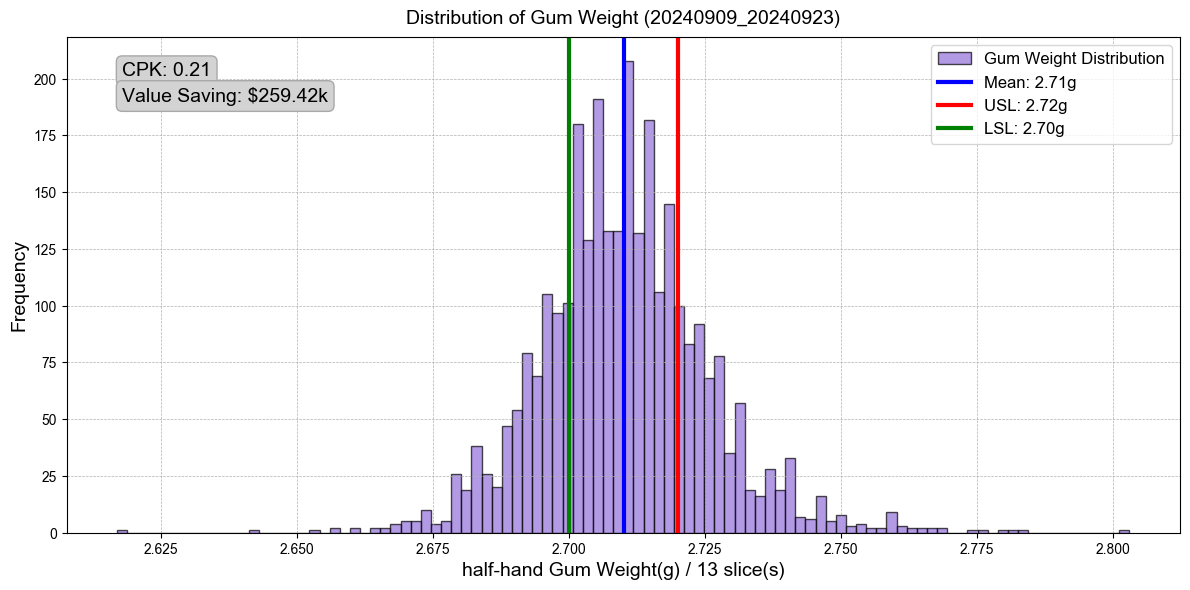

In [6]:
slice_no = 13

colors = {
    'hist_color': '#9370DB',  # purple
    'mean_color': '#0000FF',  # blue
    'usl_color': '#FF0000',  # red
    'lsl_color': '#008000',  # green
    'text_bg_color': '#D3D3D3',  # light grey
    'text_edge_color': '#A9A9A9'  # dark grey
}

# Plotting the histogram
plt.figure(figsize=(12, 6))
plt.hist(spc_data['Actual']/slice_no, bins=100, edgecolor='black', alpha=0.7, color=colors['hist_color'], label='Gum Weight Distribution')

# Plot mean, USL, and LSL
plt.axvline(spc_mean/slice_no, color=colors['mean_color'], linestyle='-', linewidth=3, label=f'Mean: {spc_mean/slice_no:.2f}g')
plt.axvline(usl/slice_no, color=colors['usl_color'], linestyle='-', linewidth=3, label=f'USL: {usl/slice_no:.2f}g')
plt.axvline(lsl/slice_no, color=colors['lsl_color'], linestyle='-', linewidth=3, label=f'LSL: {lsl/slice_no:.2f}g')

# Add title with date range and smaller font size
plt.title(f'Distribution of Gum Weight ({start_dt}_{end_dt})', fontsize=14, fontweight='bold', y=1.01)

# Add labels
plt.xlabel(f'half-hand Gum Weight(g) / {slice_no} slice(s)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Add legend
plt.legend(frameon=True, fontsize=12)

# Add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Annotate CPK and value saving
plt.text(0.05, 0.95, f'CPK: {spc_cpk:.2f}', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))
plt.text(0.05, 0.90, f'Value Saving: ${value_saving:.2f}k', transform=plt.gca().transAxes, fontsize=14, verticalalignment='top', 
         bbox=dict(boxstyle="round,pad=0.3", facecolor=colors['text_bg_color'], edgecolor=colors['text_edge_color']))

plt.tight_layout()
plt.show()

#### Calculating estimated CpK

In [65]:
from scipy.stats import norm

# Given data
usl, lsl = 2.73*13, 2.70*13
target = 2.71 * 13  # Target mean weight
percentile = 0.95  # 90% of the data  =0.9973 for CpK=1

# For 90% of the data to fall within [2.70, 2.72], we need to find the z-scores
# that correspond to the 5th percentile (lower end) and 95th percentile (upper end)
z_lower = norm.ppf((1 - percentile) / 2)
z_upper = norm.ppf(1 - (1 - percentile) / 2)

# The distance from the mean to each specification limit is proportional to the standard deviation (sigma)
# We use the lower z-score because it's more conservative (smaller sigma)
distance = (target - lsl)
sigma = distance / z_upper
variance = sigma**2

# Calculate CPU and CPL
cpu = (usl - target) / (3 * sigma)
cpl = (target - lsl) / (3 * sigma)
cpk = min(cpu, cpl)
print(f'Overall, we have a CPK of {cpk:.3f}')
print(f'Overall, we have a Variance of {variance:.3f}')

Overall, we have a CPK of 0.653
Overall, we have a Variance of 0.004
